<a href="https://colab.research.google.com/github/sidd3103/Cats-vs-Dogs/blob/master/Cats_vs_Dogs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Dog or Cat**?
In this notebook, I will create a neural network that determines whether an image is of a cat or a dog. The dataset I use is taken from Kaggle, and I only use 10% of the 20000 images to create my model. 

Created by : Siddharth Mittal

In [ ]:
import os
import zipfile
import shutil

First we need to get the zip files containing the training,validation and testing images from github. We do that by using !git clone

In [ ]:
!git clone https://github.com/sidd3103/Cats-vs-Dogs.git

Cloning into 'Cats-vs-Dogs'...
remote: Enumerating objects: 10, done.
remote: Total 10 (delta 0), reused 0 (delta 0), pack-reused 10
Unpacking objects: 100% (10/10), done.


Next, we unzip the files, delete the __MACOSX files and .DS_Store files that are created and hidden when we zip files on mac. We do all this using the OS, Shutil libraries.

In [ ]:
local_zip = 'Cats-vs-Dogs/train.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('Cats-vs-Dogs/train')
zip_ref.close()
shutil.rmtree('Cats-vs-Dogs/train/__MACOSX')

In [ ]:
local_zip = 'Cats-vs-Dogs/validation.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('Cats-vs-Dogs/validation')
zip_ref.close()
shutil.rmtree('Cats-vs-Dogs/validation/__MACOSX')

In [ ]:
local_zip = 'Cats-vs-Dogs/test.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('Cats-vs-Dogs/test')
zip_ref.close()
shutil.rmtree('Cats-vs-Dogs/test/__MACOSX')

In [ ]:
os.remove('Cats-vs-Dogs/test.zip')
os.remove('Cats-vs-Dogs/train.zip')
os.remove('Cats-vs-Dogs/validation.zip')

The following code snippet removes the hidden .DS_Store files. 
Snippet taken from : https://gist.github.com/mattsparks/19a0911999a623a3c302cc29c96b293a

In [ ]:
import glob
os.chdir('/content/Cats-vs-Dogs')
for root, dirs, files in os.walk('/'):
  i = 0
  for file in files:
    if file.endswith('.DS_Store'):
      path = os.path.join(root, file)
      if os.remove(path):
        pass
      else:
        i += 1

Now we create paths to the directories from where our ImageDataGenerator will take images for training,validation and testing.

In [ ]:
base_dir = os.path.join('/content','Cats-vs-Dogs')
train_directory = os.path.join((os.path.join(base_dir,'train')),'train')
test_directory = os.path.join((os.path.join(base_dir,'test')),'test')
validation_directory = os.path.join((os.path.join(base_dir,'validation')),'validation')

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

Our next step is to create our ImageDataGenerators using keras. Before training our model, images require preprocessing. Currently our images exist as JPEG files. We need to : 


1.   Decode these images to RGB grid of pixels. 
2.   Convert these pixels to floating-point tensors so that they can be fed into the neural network.
3.   Rescale pixels to have a value between 0 and 1.

Thankfully, all these tasks can be done using ImageDataGenerators from the keras library.


In [ ]:
datagen = ImageDataGenerator(rescale = 1./255)
train_generator = datagen.flow_from_directory(train_directory,
                                              target_size = (150,150),
                                              batch_size = 20,
                                              class_mode = 'binary')

validation_generator = datagen.flow_from_directory(validation_directory,
                                              target_size = (150,150),
                                              batch_size = 20,
                                              class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
from keras import layers
from keras import models

We define our model in the next code block.

In [ ]:
model = models.Sequential()
#First convolutional layer with 32 3x3 filters
model.add(layers.Conv2D(32, (3, 3), activation='relu',
      input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D((2, 2)))

#Second convolutional layer with 64 3x3 filters
model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#Third convolutional layer with 128 3x3 filters
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#Fourth convolutional layer with 128 3x3 filters
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#Fifth convolutional layer with 128 3x3 filters
model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))

#We flatten our final feature map and add a hidden dense layer with 512 neurons
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))

#Our output layer
model.add(layers.Dense(1, activation='sigmoid'))

Since we are tackling a binary classification problem, our output layer is of size 1 and activation 'sigmoid'. The network will give us a single probability ***p*** and since there are only two classes, the two probabilities will be ***p*** and ***1-p***.



Let's print out a summary of our model.


In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
from keras import optimizers

Now we compile and fit our model. Since it is a binary classification problem, we use 'binary_crossentropy' as our loss function and RMSprop as our optimizer with a learning rate of 0.0001. 
Since our data generator takes images in batches of 20, and we have 2000 training images, the number of steps per epoch should be 2000/20 = 100 

In [ ]:
model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-4),
metrics=['acc'])

In [ ]:
result = model.fit(
train_generator,
steps_per_epoch=100,
epochs=40,
validation_data=validation_generator,
validation_steps=50)

Epoch 1/40
100/100 [==============================] - 11s 109ms/step - loss: 0.6924 - acc: 0.5345 - val_loss: 0.6917 - val_acc: 0.5000
Epoch 2/40
100/100 [==============================] - 11s 109ms/step - loss: 0.6803 - acc: 0.5600 - val_loss: 0.6698 - val_acc: 0.6000
Epoch 3/40
100/100 [==============================] - 11s 109ms/step - loss: 0.6680 - acc: 0.5965 - val_loss: 0.6649 - val_acc: 0.6050
Epoch 4/40
100/100 [==============================] - 11s 108ms/step - loss: 0.6502 - acc: 0.6220 - val_loss: 0.6680 - val_acc: 0.5820
Epoch 5/40
100/100 [==============================] - 11s 109ms/step - loss: 0.6373 - acc: 0.6495 - val_loss: 0.6371 - val_acc: 0.6480
Epoch 6/40
100/100 [==============================] - 11s 108ms/step - loss: 0.6165 - acc: 0.6645 - val_loss: 0.6233 - val_acc: 0.6610
Epoch 7/40
100/100 [==============================] - 11s 108ms/step - loss: 0.5949 - acc: 0.6795 - val_loss: 0.6616 - val_acc: 0.6190
Epoch 8/40
100/100 [==============================] - 1

Let's visualise these results using matplotlib.


In [ ]:
import matplotlib.pyplot as plt

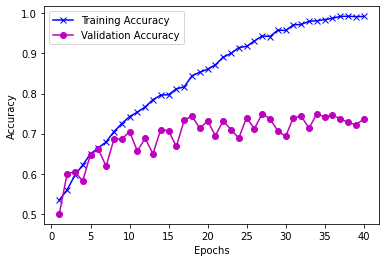

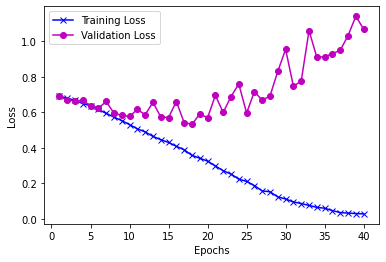

In [ ]:
acc = result.history['acc']
loss = result.history['loss']
validation_acc = result.history['val_acc']
validation_loss = result.history['val_loss']

x = range(1,len(acc)+1)

plt.plot(x,acc,'x-b',label = 'Training Accuracy')
plt.plot(x,validation_acc,'o-m',label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.plot(x,loss,'x-b',label = 'Training Loss')
plt.plot(x,validation_loss,'o-m',label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As we can see, the training accuracy increases linearly until it reaches close to 100% whereas the validation accuracy stalls close to 70%. 

Similary, the training loss falls with every epoch while the validation loss reaches it's minimum somewhere between the 6th-8th epoch, after which it starts increasing.

These plots are characteristic of intense overfitting. This is to be expected since our dataset is so small, comprising of only 2000 training images. It's 10% of the original dataset from Kaggle, which contains 20000 training images. 

#Data Augmentation 
We tackle this intense overfitting by using data augmentation. Data augmentation refers to generating more training data from existing data by applying a transformation to the original images such that the result is also the same category of image. 




In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')

In [ ]:
train_generator_with_aug = train_datagen.flow_from_directory(train_directory,
                                                    batch_size = 20,
                                                    target_size = (150,150),
                                                    class_mode = 'binary')

validation_generator = datagen.flow_from_directory(validation_directory,
                                                   batch_size = 20,
                                                   target_size = (150,150),
                                                   class_mode = 'binary')

result_aug = model.fit(train_generator_with_aug,
                       steps_per_epoch = 100,
                       epochs =50,
                       validation_data = validation_generator,
                       validation_steps = 50)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Epoch 1/50
100/100 [==============================] - 21s 209ms/step - loss: 0.9166 - acc: 0.6600 - val_loss: 0.6294 - val_acc: 0.7070
Epoch 2/50
100/100 [==============================] - 21s 207ms/step - loss: 0.6327 - acc: 0.6855 - val_loss: 0.5673 - val_acc: 0.7130
Epoch 3/50
100/100 [==============================] - 21s 207ms/step - loss: 0.5958 - acc: 0.6945 - val_loss: 0.5617 - val_acc: 0.7190
Epoch 4/50
100/100 [==============================] - 21s 207ms/step - loss: 0.5668 - acc: 0.7095 - val_loss: 0.5654 - val_acc: 0.7060
Epoch 5/50
100/100 [==============================] - 21s 207ms/step - loss: 0.5832 - acc: 0.6870 - val_loss: 0.5078 - val_acc: 0.7570
Epoch 6/50
100/100 [==============================] - 21s 206ms/step - loss: 0.5634 - acc: 0.7070 - val_loss: 0.5433 - val_acc: 0.7160
Epoch 7/50
100/100 [==============================] - 21s 208ms/step - loss: 0.5605 - acc: 0.7225 - val_lo

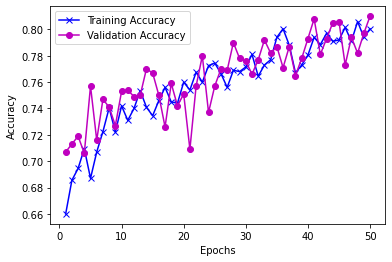

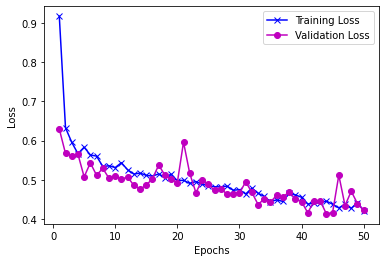

In [ ]:
acc = result_aug.history['acc']
loss = result_aug.history['loss']
validation_acc = result_aug.history['val_acc']
validation_loss = result_aug.history['val_loss']

x = range(1,len(acc)+1)

plt.plot(x,acc,'x-b',label = 'Training Accuracy')
plt.plot(x,validation_acc,'o-m',label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.plot(x,loss,'x-b',label = 'Training Loss')
plt.plot(x,validation_loss,'o-m',label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Clearly, we are no longer overfitting because of a larger training sample due to data augmentation. The validation curves are closely tracking the training curves for the most part, with some hiccups in between.

The accuracy reaches to about 82%, which is almost a 17% increase from our previous accuracy without augmentation.

#Using a Pre-Trained Model (Feature Extraction)
We can further improve our accuracy by using a pretrained model such as ResNet50, VGG16, VGG19, etc. 
Each convolutional neural network has two parts : 

1. The **convulational base** consisting of the pooling and convolutional layers. 
2. The **densely connected classifier** that sits on top of the convolutional base

We just need to take the convulational base of the pre-trained network and add it on top of our classifier.
The patterns and features learned by the convolutional base are more generic and hence more reusable. The classifier, on the other hand, recognises and learns local patterns in the dataset. Hence, we avoid using the classifier of the pretrained model and use only the convolutional base instead.



The VGG16 model was trained on the ImageNet dataset which contains many images of dogs and cats, so we can use the classifier as well. But to have a more generic model, we won't use it and build our own classifier.

In [ ]:
from keras.applications import VGG16

In [ ]:
vgg16_base = VGG16(include_top = False,
                   weights = 'imagenet',
                   input_shape = (150,150,3))

In [ ]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

Before compiling and training the model, we have to freeze the convolutional base. If we don't do this, the patterns that were previously learned by the model would be updated during the training. 

In [ ]:
#Freezing the convoutional base
vgg16_base.trainable = False

In [ ]:
new_model = models.Sequential()
new_model.add(vgg16_base)
new_model.add(layers.Flatten())
new_model.add(layers.Dense(256,activation = 'relu'))
new_model.add(layers.Dense(1,activation = 'sigmoid'))

In [ ]:
new_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [ ]:
new_model.compile(optimizer = optimizers.RMSprop(lr = 2e-5),
                  loss = 'binary_crossentropy',
                  metrics = 'acc')

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   horizontal_flip = True,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   fill_mode = 'nearest')

train_generator_vgg16 = train_datagen.flow_from_directory(train_directory, 
                                                          target_size = (150,150),
                                                          batch_size = 20,
                                                          class_mode = 'binary')

validation_generator = datagen.flow_from_directory(validation_directory,
                                                   target_size = (150,150),
                                                   batch_size = 20,
                                                   class_mode = 'binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:
result_vgg16 = new_model.fit(train_generator_vgg16,
                       steps_per_epoch = 100,
                       epochs =50,
                       validation_data = validation_generator,
                       validation_steps = 50)

Epoch 1/50
100/100 [==============================] - 25s 255ms/step - loss: 0.6136 - acc: 0.6640 - val_loss: 0.4621 - val_acc: 0.8210
Epoch 2/50
100/100 [==============================] - 25s 253ms/step - loss: 0.4952 - acc: 0.7705 - val_loss: 0.3799 - val_acc: 0.8600
Epoch 3/50
100/100 [==============================] - 25s 252ms/step - loss: 0.4271 - acc: 0.8165 - val_loss: 0.3346 - val_acc: 0.8660
Epoch 4/50
100/100 [==============================] - 25s 252ms/step - loss: 0.4076 - acc: 0.8165 - val_loss: 0.3462 - val_acc: 0.8480
Epoch 5/50
100/100 [==============================] - 25s 251ms/step - loss: 0.3847 - acc: 0.8290 - val_loss: 0.3040 - val_acc: 0.8760
Epoch 6/50
100/100 [==============================] - 25s 251ms/step - loss: 0.3748 - acc: 0.8425 - val_loss: 0.2853 - val_acc: 0.8830
Epoch 7/50
100/100 [==============================] - 25s 252ms/step - loss: 0.3584 - acc: 0.8470 - val_loss: 0.2756 - val_acc: 0.8840
Epoch 8/50
100/100 [==============================] - 2

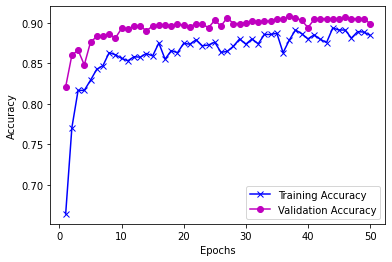

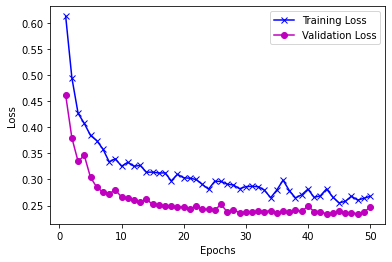

In [ ]:
acc = result_vgg16.history['acc']
loss = result_vgg16.history['loss']
validation_acc = result_vgg16.history['val_acc']
validation_loss = result_vgg16.history['val_loss']

x = range(1,len(acc)+1)

plt.plot(x,acc,'x-b',label = 'Training Accuracy')
plt.plot(x,validation_acc,'o-m',label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.plot(x,loss,'x-b',label = 'Training Loss')
plt.plot(x,validation_loss,'o-m',label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Our training accuracy reaches upto 88% while our validation accuracy reaches almost 90%. Similarly, our training loss is more than our validation loss for every epoch. That's unusual to see. 

Usually we see this when we apply regularization techniques to our model such as adding a dropout layer. The dropout layer gets applied to training images but not the validation images.

But it is not the case here. It might be because the weights of VGG16 convolutional base recognise the patterns in validation images better than in the training images.

#Fine Tuning
Fine tuning consists of unfreezing a few of the top layers of the convolutional base and training those layers after our classifier has already been trained. If the classifier hasn't already been trained, the patterns learned by the layers being fine-tuned will be destroyed.

In [ ]:
vgg16_base.trainable = True
for layer in vgg16_base.layers:
  if layer.name == 'block5_conv1':
    break
  layer.trainable = False

In [ ]:
vgg16_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [ ]:
new_model.compile(loss='binary_crossentropy',
optimizer=optimizers.RMSprop(lr=1e-5),
metrics='acc')

In [ ]:
result_fine_tune = new_model.fit(train_generator_vgg16,
                                 steps_per_epoch = 100,
                                 epochs = 20,
                                 validation_data = validation_generator,
                                 validation_steps = 50)

Epoch 1/20
100/100 [==============================] - 27s 267ms/step - loss: 0.0556 - acc: 0.9815 - val_loss: 0.2204 - val_acc: 0.9360
Epoch 2/20
100/100 [==============================] - 26s 263ms/step - loss: 0.0478 - acc: 0.9820 - val_loss: 0.2324 - val_acc: 0.9350
Epoch 3/20
100/100 [==============================] - 26s 264ms/step - loss: 0.0542 - acc: 0.9800 - val_loss: 0.2066 - val_acc: 0.9410
Epoch 4/20
100/100 [==============================] - 26s 264ms/step - loss: 0.0378 - acc: 0.9855 - val_loss: 0.1956 - val_acc: 0.9430
Epoch 5/20
100/100 [==============================] - 26s 263ms/step - loss: 0.0381 - acc: 0.9850 - val_loss: 0.2800 - val_acc: 0.9310
Epoch 6/20
100/100 [==============================] - 26s 263ms/step - loss: 0.0521 - acc: 0.9835 - val_loss: 0.2478 - val_acc: 0.9310
Epoch 7/20
100/100 [==============================] - 26s 262ms/step - loss: 0.0442 - acc: 0.9865 - val_loss: 0.1989 - val_acc: 0.9390
Epoch 8/20
100/100 [==============================] - 2

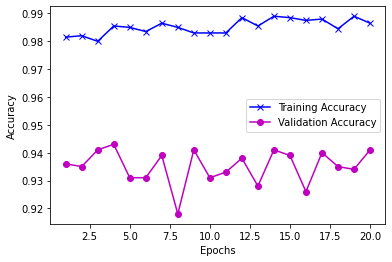

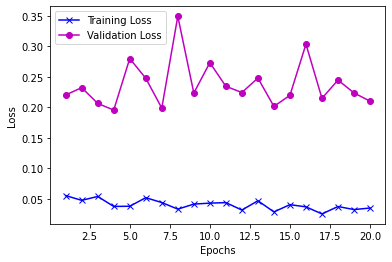

In [ ]:
acc = result_fine_tune.history['acc']
loss = result_fine_tune.history['loss']
validation_acc = result_fine_tune.history['val_acc']
validation_loss = result_fine_tune.history['val_loss']

x = range(1,len(acc)+1)

plt.plot(x,acc,'x-b',label = 'Training Accuracy')
plt.plot(x,validation_acc,'o-m',label = 'Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.figure()
plt.plot(x,loss,'x-b',label = 'Training Loss')
plt.plot(x,validation_loss,'o-m',label = 'Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

As we can see, our validation accuracy has increased to almost 94% by fine-tuning our model. This is a really good accuracy considering we are working with only 2000 training images. There is still overfitting a lot of room to improve our model but for now, let's test this model on completely unseen data. 

In [ ]:
test_generator = datagen.flow_from_directory(
test_directory,
target_size=(150, 150),
batch_size = 25,
class_mode='binary')

Found 1000 images belonging to 2 classes.


In [ ]:
test_loss, test_accuracy = new_model.evaluate(test_generator, steps=40)
print('test accuracy: ' + str(test_accuracy*100) + '%')

40/40 [==============================] - 5s 119ms/step - loss: 0.2695 - acc: 0.9400
test accuracy: 93.99999976158142%


We get an accuracy of almost 94% on our test sample. 

Try out the model by uploading cat or dog images from your local machine by running the next two cells.

In [ ]:
if os.getcwd() != '/content':
  os.chdir('/content')

In [ ]:

import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
  path = '/content/' + fn
  img = image.load_img(path, target_size=(150, 150))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  probability = new_model.predict(images, batch_size=10)
  if probability > 0.5:
    print('Image is of a dog.')
  elif probability < 0.5:
    print('Image is of a cat.')
  else:
    print('Image is ambiguous. ')
  os.remove(path)

Saving 28.jpg to 28.jpg
Image is of a cat.
